In [10]:
# 0.0. Importando as libs

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import os

# 0.1. Construindo a path de input e importanto o dataframe

script_path = os.getcwd()
cutting_string = "Scripts"

partes = script_path.split(cutting_string)
path_insumos = partes[0] + "Insumos\\Semi-tratado (v2)"

df = pd.read_excel(path_insumos + "\\Semitratado.xlsx")

# 1.0. Construindo função de limpeza casual

def limpeza_casual(df, colunas):

    # Selecionar apenas as colunas desejadas
    temp_df = df[colunas].copy()
    
    # Remover linhas que contêm qualquer valor NaN nas colunas selecionadas
    temp_df.dropna(inplace=True)
    
    return temp_df

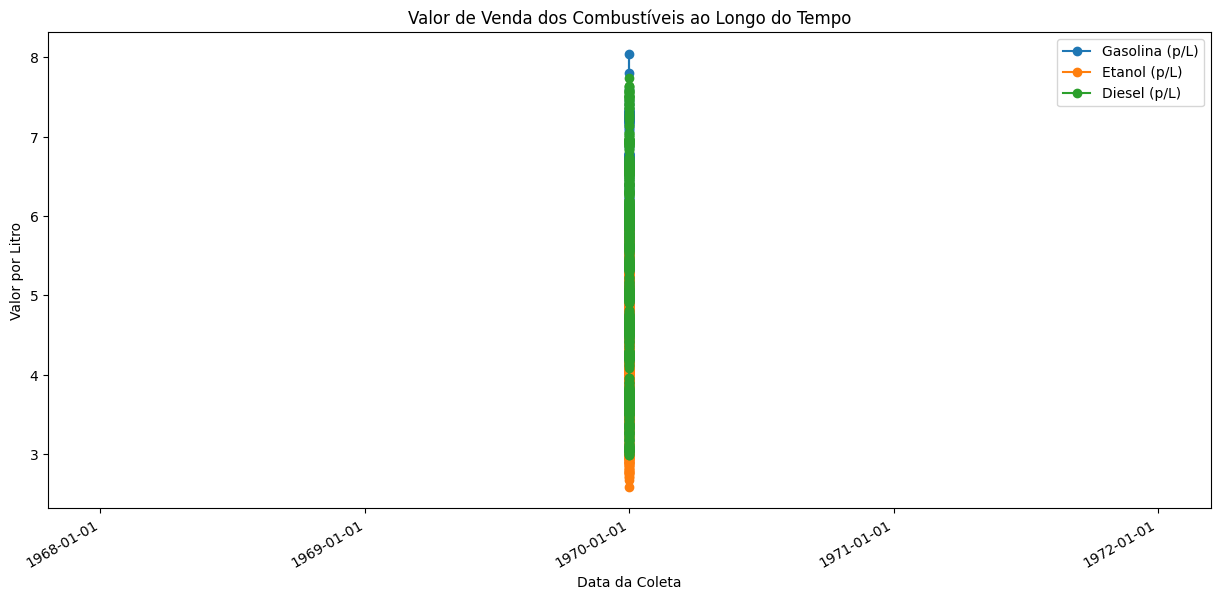

In [11]:
# 2.0. 

temp_df = limpeza_casual(df, ['Data da Coleta',
                              'Valor de Venda Gasolina (p/L)', 
                              'Valor de Venda Etanol (p/L)',
                              'Valor de Venda Diesel (p/L)'])

# --- #

temp_df['Data da Coleta'] = pd.to_datetime(temp_df['Data da Coleta'])

# Criando o plot
plt.figure(figsize=(15, 7))
plt.plot(temp_df['Data da Coleta'], temp_df['Valor de Venda Gasolina (p/L)'], label='Gasolina (p/L)', marker='o')
plt.plot(temp_df['Data da Coleta'], temp_df['Valor de Venda Etanol (p/L)'], label='Etanol (p/L)', marker='o')
plt.plot(temp_df['Data da Coleta'], temp_df['Valor de Venda Diesel (p/L)'], label='Diesel (p/L)', marker='o')

# Formatando o eixo x para mostrar as datas
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate() # Auto formatar as datas para evitar sobreposição

# Adicionando título e labels
plt.title('Valor de Venda dos Combustíveis ao Longo do Tempo')
plt.xlabel('Data da Coleta')
plt.ylabel('Valor por Litro')
plt.legend()

# Mostrar o gráfico
plt.show()